### **Sentimant Analysis on Google News about Covid-19**

---



### **Load Dataset**

Install live data from Google news API

In [232]:
pip install GoogleNews

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Import necessary libraries

In [ ]:
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import spacy
import datetime as dt

nltk.download('all')

Load Dataset

In [234]:
from GoogleNews import GoogleNews
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
from nltk.collections import Counter
pos_spacy = spacy.load("en_core_web_sm")
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

Define a keyword to search in the Google news Api

In [236]:
keyword = 'Covid-19'

Perform news scraping from Google and extract the result into Pandas dataframe.

In [237]:
googlenews = GoogleNews(lang='en', region='IN', period='20d', encode='utf-8')
googlenews.clear()
googlenews.search(keyword)
googlenews.get_page(15)
news_result = googlenews.result(sort=True)
news_data_df = pd.DataFrame.from_dict(news_result)

Export dataframe to csv file

In [238]:
news_data_df.to_csv('Covid-19_google_news_sentiment_analysis.csv', index=False, encoding="utf-8-sig")

### **Data Preprocessing**

Information on DataFrame

In [239]:
news_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   title     20 non-null     object        
 1   media     20 non-null     object        
 2   date      20 non-null     object        
 3   datetime  20 non-null     datetime64[ns]
 4   desc      20 non-null     object        
 5   link      20 non-null     object        
 6   img       20 non-null     object        
dtypes: datetime64[ns](1), object(6)
memory usage: 1.2+ KB


Checking null values

In [240]:
news_data_df.isnull().sum()

title       0
media       0
date        0
datetime    0
desc        0
link        0
img         0
dtype: int64

Filling missing Values

In [241]:
news_data_df.fillna(value = "", inplace = True)

In [242]:
news_data_df.head()

,title,media,date,datetime,desc,link,img
0,McHenry County reports one more COVID-19 death...,Shaw Local,3 mins ago,2023-04-14 21:20:22.834762,"For 12 straight weeks, McHenry County's COVID-...",https://www.shawlocal.com/northwest-herald/cor...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////..."
1,6 Stateline counties at Medium Community level...,WREX,4 mins ago,2023-04-14 21:19:22.828925,The Illinois Department of Health reports that...,https://www.wrex.com/coronavirus/6-stateline-c...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////..."
2,Fact check: New COVID-19 variants still found ...,USA Today,Fact check article · 6 mins ago,2023-04-14 21:17:22.810623,Multiple new variants of the virus that causes...,https://www.usatoday.com/story/news/factcheck/...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////..."
3,Watching the wastewater: Mass. COVID at lowest...,WBUR,7 mins ago,2023-04-14 21:16:22.824537,A new study out of Massachusetts also suggests...,https://www.wbur.org/news/2023/04/14/covid-was...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////..."
4,What Is the Arcturus Omicron XBB.1.16 Subvariant?,Everyday Health,8 mins ago,2023-04-14 21:15:22.819915,A new COVID-19 omicron variant is driving up c...,https://www.everydayhealth.com/coronavirus/who...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////..."


Performing tokenization, lemmatization, removing stop words and removing HTML tag

In [243]:
def preprocess_text(text):

    # Tokenize the text
    tokens = word_tokenize(text.lower())

    # Removing HTML Tags
    soup = BeautifulSoup(text, 'lxml')
    return soup.get_text()

    # Remove stop words
    filtered_tokens = [token for token in soup if token not in stopwords.words('english')]

    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]

    # Join the tokens back into a string
    processed_text = ' '.join(lemmatized_tokens)
    return processed_text

news_data_df['desc'] = news_data_df['desc'].apply(preprocess_text)
news_data_df['desc']



<ipython-input-243-588d4be609ed>:7: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'lxml')


0     For 12 straight weeks, McHenry County's COVID-...
1     The Illinois Department of Health reports that...
2     Multiple new variants of the virus that causes...
3     A new study out of Massachusetts also suggests...
4     A new COVID-19 omicron variant is driving up c...
5     Federal prosecutors accused a pair of brothers...
6     INDIANAPOLIS (WISH) – The Indiana Department o...
7     Brothers from Palm Beach County and Miramar we...
8     An average 243 people a day test positive for ...
9     This past week President Joe Biden signed into...
10    The AMA is closely monitoring COVID-19 (2019 n...
11    This tracker provides data on global COVID-19 ...
12    Data is updated every other week. Next Update:...
13    Chronic absenteeism in schools persists around...
14    The Public Health Agency (PHA) in Northern Ire...
15    When the curtain came down on March 12, 2020, ...
16    In December 2020, before the rollout of the Co...
17    The U.S. national emergency to respond to 

Selecting adjectives from the news description and appending them to our dataframe

### **Sentiment Analysis**

In [244]:
def percentage(part,whole):
    return 100 * float(part)/float(whole)

#Assigning Initial Values
positive = 0
negative = 0
neutral = 0
#Creating empty lists
news_list = []
neutral_list = []
negative_list = []
positive_list = []
df_new = []
senti_value = []

#Iterating over the news in the dataframe
for news in news_data_df['desc']:
    news_list.append(news)
    analyzer = SentimentIntensityAnalyzer().polarity_scores(news)

    neg = analyzer['neg']
    df_new.append(neg)
    senti_value.append("-1")

    neu = analyzer['neu']
    df_new.append(neu)
    senti_value.append("0")

    pos = analyzer['pos']
    df_new.append(pos)
    senti_value.append("+1")

    comp = analyzer['compound']   
    news_data_df['weigh_of_sentiment'] = pd.Series(df_new)
    news_data_df['sentiment'] = pd.Series(senti_value)

    if neg > pos:
        negative_list.append(news) #appending the news that satisfies this condition
        negative += 1 #increasing the count by 1
    elif pos > neg:
        positive_list.append(news) #appending the news that satisfies this condition
        positive += 1 #increasing the count by 1
    elif pos == neg:
        neutral_list.append(news) #appending the news that satisfies this condition
        neutral += 1 #increasing the count by 1 

positive = percentage(positive, len(news_data_df)) #percentage is the function defined above
negative = percentage(negative, len(news_data_df))
neutral = percentage(neutral, len(news_data_df))

#Converting lists to pandas dataframe
news_list = pd.DataFrame(news_list)
neutral_list = pd.DataFrame(neutral_list)
negative_list = pd.DataFrame(negative_list)
positive_list = pd.DataFrame(positive_list)
#using len(length) function for counting
print("Positive Sentiment:", '%.2f' % len(positive_list), end='\n')
print("Neutral Sentiment:", '%.2f' % len(neutral_list), end='\n')
print("Negative Sentiment:", '%.2f' % len(negative_list), end='\n')



Positive Sentiment: 5.00
Neutral Sentiment: 8.00
Negative Sentiment: 7.00


In [245]:
news_data_df.head()

,title,media,date,datetime,desc,link,img,weigh_of_sentiment,sentiment
0,McHenry County reports one more COVID-19 death...,Shaw Local,3 mins ago,2023-04-14 21:20:22.834762,"For 12 straight weeks, McHenry County's COVID-...",https://www.shawlocal.com/northwest-herald/cor...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////...",0.000,-1
1,6 Stateline counties at Medium Community level...,WREX,4 mins ago,2023-04-14 21:19:22.828925,The Illinois Department of Health reports that...,https://www.wrex.com/coronavirus/6-stateline-c...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////...",0.917,0
2,Fact check: New COVID-19 variants still found ...,USA Today,Fact check article · 6 mins ago,2023-04-14 21:17:22.810623,Multiple new variants of the virus that causes...,https://www.usatoday.com/story/news/factcheck/...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////...",0.083,+1
3,Watching the wastewater: Mass. COVID at lowest...,WBUR,7 mins ago,2023-04-14 21:16:22.824537,A new study out of Massachusetts also suggests...,https://www.wbur.org/news/2023/04/14/covid-was...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////...",0.000,-1
4,What Is the Arcturus Omicron XBB.1.16 Subvariant?,Everyday Health,8 mins ago,2023-04-14 21:15:22.819915,A new COVID-19 omicron variant is driving up c...,https://www.everydayhealth.com/coronavirus/who...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////...",1.000,0


### **Data Visualization**

Visualize news description sentiment by pie chart

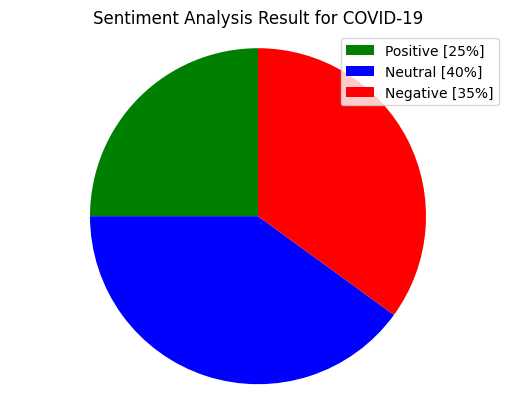

In [246]:
labels = ['Positive ['+str(round(positive))+'%]' , 'Neutral ['+str(round(neutral))+'%]','Negative ['+str(round(negative))+'%]']
sizes = [positive, neutral, negative]
colors = ['green', 'blue','red']
patches, texts = plt.pie(sizes,colors=colors, startangle=90)
plt.style.use('default')
plt.legend(labels)
plt.title("Sentiment Analysis Result for COVID-19")
plt.axis('equal')
plt.show()

### **Looking at the most common adjectives**

Selecting adjectives from the news description and appending them to dataframe

In [247]:
pos_adj=[]
for token in news_data_df['desc']:
    desc = pos_spacy(token)
    pos_token = [tok.lemma_.lower().strip() for tok in desc if tok.pos_ == 'ADJ']
    pos_adj.append(pos_token)

news_data_df['pos_adj'] = pd.Series(pos_adj)



In [248]:
news_data_df.head()

,title,media,date,datetime,desc,link,img,weigh_of_sentiment,sentiment,pos_adj
0,McHenry County reports one more COVID-19 death...,Shaw Local,3 mins ago,2023-04-14 21:20:22.834762,"For 12 straight weeks, McHenry County's COVID-...",https://www.shawlocal.com/northwest-herald/cor...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////...",0.000,-1,"[straight, low]"
1,6 Stateline counties at Medium Community level...,WREX,4 mins ago,2023-04-14 21:19:22.828925,The Illinois Department of Health reports that...,https://www.wrex.com/coronavirus/6-stateline-c...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////...",0.917,0,[]
2,Fact check: New COVID-19 variants still found ...,USA Today,Fact check article · 6 mins ago,2023-04-14 21:17:22.810623,Multiple new variants of the virus that causes...,https://www.usatoday.com/story/news/factcheck/...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////...",0.083,+1,"[multiple, new, public]"
3,Watching the wastewater: Mass. COVID at lowest...,WBUR,7 mins ago,2023-04-14 21:16:22.824537,A new study out of Massachusetts also suggests...,https://www.wbur.org/news/2023/04/14/covid-was...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////...",0.000,-1,"[new, dangerous, few]"
4,What Is the Arcturus Omicron XBB.1.16 Subvariant?,Everyday Health,8 mins ago,2023-04-14 21:15:22.819915,A new COVID-19 omicron variant is driving up c...,https://www.everydayhealth.com/coronavirus/who...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////...",1.000,0,[new]


Looking at most common positive adjectives used in News description

In [249]:
positive_adj = news_data_df[news_data_df['sentiment']=="+1"]['pos_adj']
pos_words = [token for token in positive_adj for token in set(token)]
pos_adj_counter = Counter(pos_words). most_common(15)
print(pos_adj_counter)

[('new', 1), ('multiple', 1), ('public', 1), ('federal', 1), ('worth', 1), ('positive', 1), ('average', 1), ('global', 1), ('current', 1), ('serious', 1), ('national', 1)]


Looking at most common negative adjectives used in News description

In [250]:
negative_adj = news_data_df[news_data_df['sentiment']=="-1"]['pos_adj']
pos_words = [token for token in negative_adj for token in set(token)]
pos_adj_counter = Counter(pos_words). most_common(15)
print(pos_adj_counter)

[('new', 2), ('few', 2), ('past', 2), ('low', 1), ('straight', 1), ('dangerous', 1), ('national', 1), ('official', 1), ('other', 1), ('raw', 1), ('daily', 1), ('more', 1)]


Looking at most common neutral adjectives used in News description

In [251]:
neutral_adj = news_data_df[news_data_df['sentiment']=="0"]['pos_adj']
pos_words = [token for token in neutral_adj for token in set(token)]
pos_adj_counter = Counter(pos_words). most_common(15)
print(pos_adj_counter)

[('new', 1), ('pandemic', 1), ('more', 1), ('chronic', 1), ('covid', 1), ('many', 1), ('legal', 1)]
